# SVM, Decision Trees, and Random Forest:

This tutorial will focus on Support Vector Machines, Decision Trees, and Random Forest. We will be using [sci-kit learn's](https://scikit-learn.org/stable/index.html) package for these models.

In [1]:
# import sklearn objects
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# importing numpy and pandas
import numpy as np
import pandas as pd

# import plotting functions
import matplotlib.pyplot as plt
import matplotlib.colors
from cycler import cycler
binary_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#332288', 'white', '#AA4499'])
plt.rcParams["axes.prop_cycle"] = cycler(
    color=['#332288','#88CCEE','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']
    )

# class for holding the random state throughout the notebook.
# this keeps results consistent
class RandomState(object):
    def __init__(self, random_state=None):
        self.random_state = random_state
    def next(self):
        self.random_state,\
            out_state = np.random.default_rng(self.random_state).integers(0, 1e9, size=(2,))
        return out_state

In [2]:
random_state = RandomState(42)

## Loading the Data:

In [3]:
# loading the dataset
bc_data = datasets.load_breast_cancer(as_frame=True)

In [4]:
# accessing the data or the target from the dataset loaded above
bc_features = bc_data.data
bc_target = bc_data.target

The first 5 lines of this data look as follows:

In [5]:
bc_features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


And the targets are as follows:

In [6]:
bc_target.value_counts()

1    357
0    212
Name: target, dtype: int64

We will cut the dataset to the mean features to make thing slightly easier:

In [7]:
bc_mean_features = bc_features[
    ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension']
    ]

We can use [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualise the data in two dimensions:

/tmp/ipykernel_7986/3504014926.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


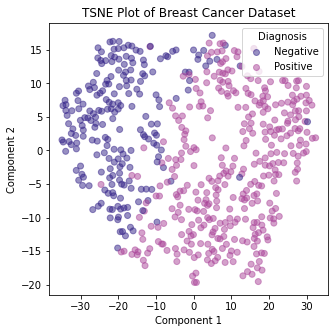

In [8]:
# import TSNE
from sklearn.manifold import TSNE

# pre-processing the data
scaler = StandardScaler()
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_state.next())
x = tsne.fit_transform(scaler.fit_transform(bc_mean_features))

# setting the figure
fig, ax = plt.subplots(1,1,figsize=(5,5))

# plotting the data
scatter = ax.scatter(
    x=x[:,0], 
    y=x[:,1], 
    c=bc_target.astype(bool), 
    alpha=0.5, 
    cmap=binary_cmap,
    )

# adding the legend
ax.legend(
    scatter.legend_elements(num=1)[0],
    ['Negative', 'Positive'],
    loc="upper right", 
    title="Diagnosis",
    )

# set title and labels
ax.set_title('TSNE Plot of Breast Cancer Dataset')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# showing plot
fig.show()

The values of the features are distributed as follows:

/tmp/ipykernel_7986/2735073717.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


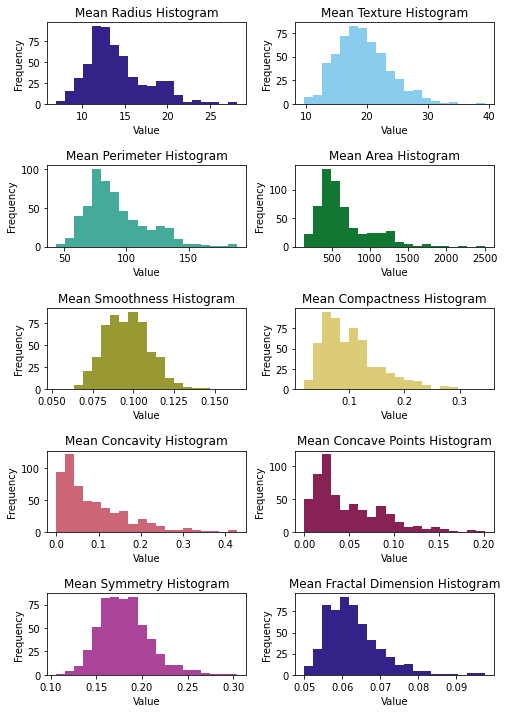

In [9]:
# setting the plotting area
fig, axes = plt.subplots(5,2, figsize=(8,12))

# getting the column names
column_names = bc_mean_features.columns
# getting the colours to make the plot look nicer!
colors = plt.rcParams["axes.prop_cycle"]()

# looping over the subplots and the column names together
for ax, col in zip(np.ravel(axes), column_names):
    # plotting a histogram
    ax.hist(
        bc_mean_features[col], # the data, accessed by the column name 
        color=next(colors)["color"], # the colour to look nicer!
        bins=20 # the number of bins
        )
    # setting the title and labels
    ax.set_title(f"{col.title()} Histogram")
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')

# setting plotting formats
fig.subplots_adjust(hspace=0.75, wspace=0.25)

# showing plot
fig.show()

## SVM

[Supprt Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) is a classic machine learning classifier that attempts to separate classes of data using a [hyperplane](https://en.wikipedia.org/wiki/Hyperplane). 

It works by maximising the width of the gap between two categories, when they are linearly separable by minimising the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss).

Different kernels can be used to learn different boundaries between classes, that might have different distributions. In the following examples, we will see where these different kernels will be helpful.

See Also: https://scikit-learn.org/stable/modules/svm.html#support-vector-machines

### The Basics

To access the [SVM code from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), we need to import it as follows:

In [10]:
from sklearn.svm import SVC

What arguments can we supply this model and what are the defaults?

In [11]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

These arguments are explained in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). For the following experiments, we will be varying the kernel function, to see how it can affect the classification performance on different datasets:

We will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a synthetic dataset:

In [13]:
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [14]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipykernel_7986/386109285.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


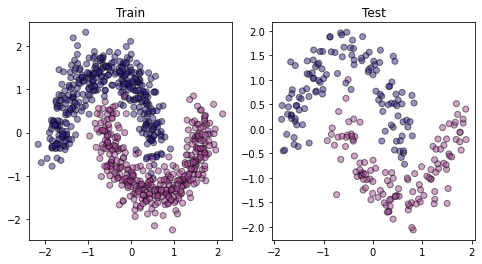

In [15]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [16]:
# start with linear kernel
svc = SVC(kernel='linear', random_state=random_state.next())

In [17]:
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=745137746)

Let's evaluate the model and see how well its decision boundary fit the data:

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print(f"The accuracy is {accuracy_score(y_test, svc.predict(X_test))*100}%")

The accuracy is 86.0%


/tmp/ipykernel_7986/125749605.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


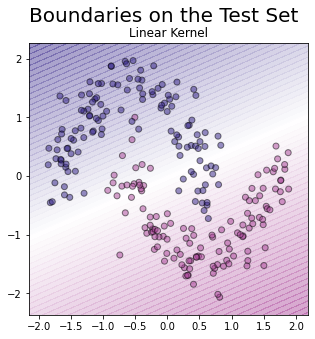

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=svc,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='decision_function',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Linear Kernel')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
fig.show()

This doesn't fit the data correctly, we can see that the linear kernel is not designed for this dataset. In the following, we will try many different kernels:

/tmp/ipykernel_7986/3411990512.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


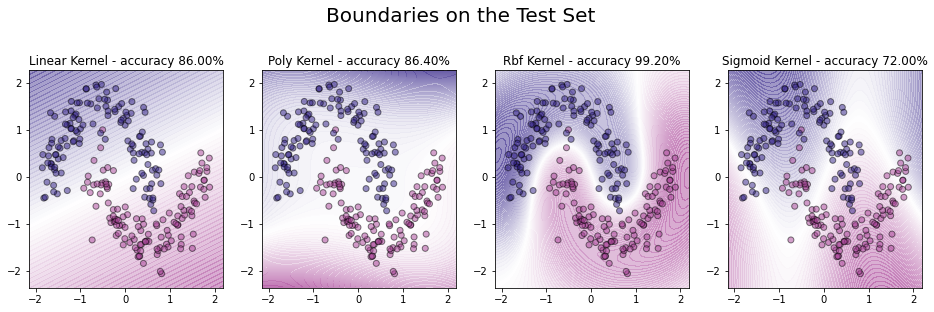

In [21]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

fig, axes = plt.subplots(1,len(kernels),figsize=(len(kernels)*4,4))

# looping over kernels
for nk, kernel in enumerate(kernels):
    ax = np.ravel(axes)[nk] # getting the current axis

    # fitting the model
    svc = SVC(kernel=kernel, random_state=random_state.next())
    svc.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=svc,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='decision_function',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'{kernel.title()} Kernel - '\
        f'accuracy {accuracy_score(y_test, svc.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Clearly, in this example, the RBF kernel was the best!

But in which cases are the different kernels better?

In [22]:
# generating datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [23]:
# kernel names
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

/tmp/ipykernel_7986/1929791253.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


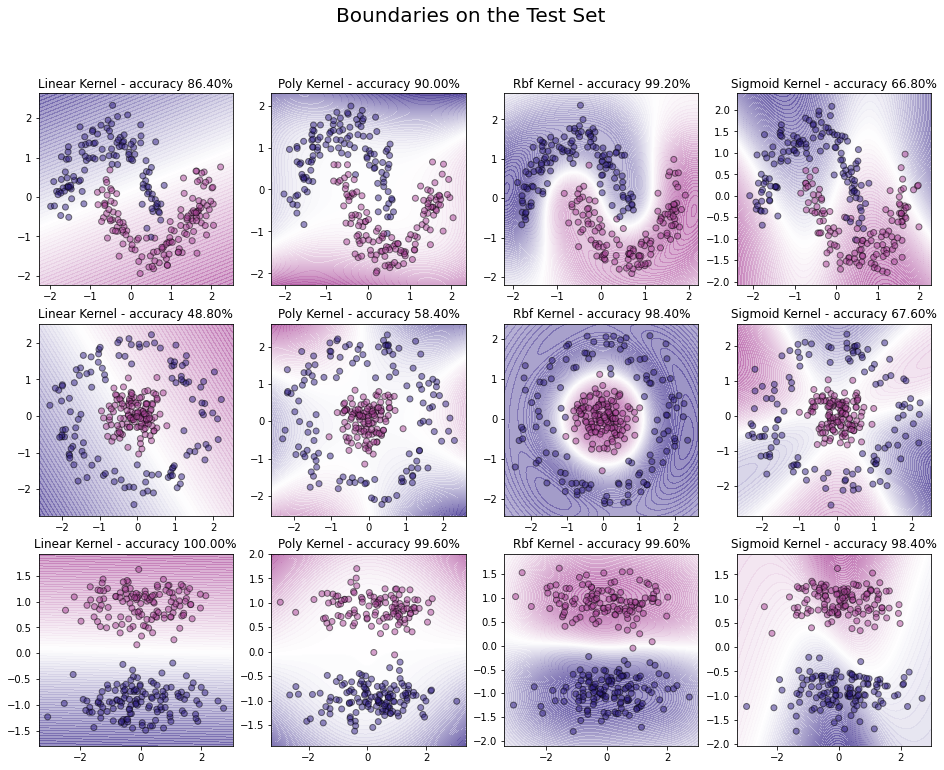

In [24]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(kernels), figsize=(len(kernels)*4,len(data_dict)*4),
    )

# looping over kernels
for nd, data in enumerate(data_dict):
    for nk, kernel in enumerate(kernels):
        
        # getting the current axis
        ax = axes[nd, nk]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        svc = SVC(kernel=kernel, random_state=random_state.next())
        svc.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=svc,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='decision_function',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'{kernel.title()} Kernel - '\
            f'accuracy {accuracy_score(y_test, svc.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use SVM to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [25]:
bc_mean_features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


And our targets are:

In [26]:
bc_target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [27]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which of the SVM models might be the best predictor of breast cancer on this dataset.

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=SVC(random_state=random_state.next()), # the model
    param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}, # the parameters to change in the search
    scoring='accuracy',  # how to score the parameters
    refit=True, # return the best model fitted on all of the training data
    cv=5, # the number of cross-validated folds
    verbose=4, # print lots of info as the code is running
    )

In [30]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....................kernel=linear;, score=0.930 total time=   0.0s
[CV 2/5] END .....................kernel=linear;, score=0.941 total time=   0.0s
[CV 3/5] END .....................kernel=linear;, score=0.882 total time=   0.0s
[CV 4/5] END .....................kernel=linear;, score=0.941 total time=   0.0s
[CV 5/5] END .....................kernel=linear;, score=0.918 total time=   0.0s
[CV 1/5] END .......................kernel=poly;, score=0.907 total time=   0.0s
[CV 2/5] END .......................kernel=poly;, score=0.918 total time=   0.0s
[CV 3/5] END .......................kernel=poly;, score=0.847 total time=   0.0s
[CV 4/5] END .......................kernel=poly;, score=0.929 total time=   0.0s
[CV 5/5] END .......................kernel=poly;, score=0.859 total time=   0.0s
[CV 1/5] END ........................kernel=rbf;, score=0.953 total time=   0.0s
[CV 2/5] END ........................kernel=rbf;,

GridSearchCV(cv=5, estimator=SVC(random_state=742779069),
             param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=4)

In [31]:
print('The results were:')
pd.DataFrame(gscv.cv_results_)

The results were:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001342,0.000195,0.000307,0.000087,linear,{'kernel': 'linear'},0.930233,0.941176,0.882353,0.941176,0.917647,0.922517,0.021876,3
1,0.001338,0.000066,0.000309,0.000004,poly,{'kernel': 'poly'},0.906977,0.917647,0.847059,0.929412,0.858824,0.891984,0.032870,4
2,0.001361,0.000126,0.000379,0.000015,rbf,{'kernel': 'rbf'},0.953488,0.941176,0.917647,0.964706,0.929412,0.941286,0.016716,1
3,0.001693,0.000049,0.000359,0.000017,sigmoid,{'kernel': 'sigmoid'},0.918605,0.952941,0.905882,0.929412,0.917647,0.924897,0.015878,2


In [32]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'kernel': 'rbf'}


In [33]:
best_model = gscv.best_estimator_
best_model

SVC(random_state=742779069)

The accuracy of this model on the test data is:

In [34]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 96.50%


## Decision Trees

[Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning) is a classic machine learning classifier that attempts to separate classes of data by learning a rule based system on the features independently. Because of this, we actually do not need to scale the data, since all features are split separately.

At each iteration, the next split is performed on the feature that optimises the criterion most. For example, when using [Gini Impurity](https://victorzhou.com/blog/gini-impurity/), we want to make a split where the Gini Impurity is reduced the most between before and after the split is made.

See also: https://scikit-learn.org/stable/modules/tree.html#decision-trees

### The Basics

The decision tree classifier is easily imported from sklearn:

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
print(f"This has the default parameters:\n {DecisionTreeClassifier().get_params()}")

This has the default parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


What each of these parameters refers to can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). We will investigate how this decision tree can be used to classify data:

Similarly to earlier, we will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a synthetic dataset:

In [38]:
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [39]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipykernel_7986/386109285.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


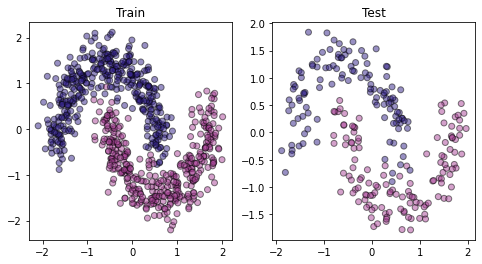

In [40]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [41]:
# start with linear kernel
dt = DecisionTreeClassifier(random_state=random_state.next())

In [42]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=937095702)

Let's evaluate the model and see how well its decision boundary fit the data:

In [43]:
from sklearn.metrics import accuracy_score

Without any tuning, this model already performs much better than SVM. Let us try and see why.

In [44]:
print(f"The accuracy is {accuracy_score(y_test, dt.predict(X_test))*100}%")

The accuracy is 96.8%


/tmp/ipykernel_7986/591171850.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


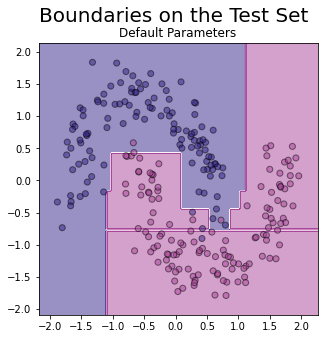

In [45]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=dt,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='predict_proba',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Default Parameters')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
fig.show()

We can see that this mostly fits the data, but has clearly tried to over fit to the few datapoints from the pink class that fall within the purple moon.

Let's study how the max depth of the tree can effect the performance:

/tmp/ipykernel_7986/910541339.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


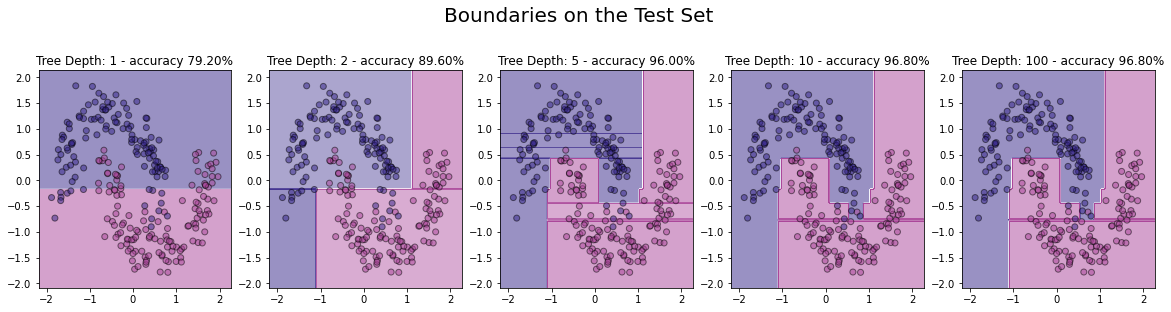

In [46]:
max_depths = [1, 2, 5, 10, 100]

fig, axes = plt.subplots(1, len(max_depths), figsize=(len(max_depths)*4,4))

# looping over max_depths
for nmd, max_depth in enumerate(max_depths):
    # getting the current axis
    ax = np.ravel(axes)[nmd]

    # fitting the model
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state.next())
    dt.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=dt,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='predict_proba',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'Tree Depth: {max_depth} - '\
        f'accuracy {accuracy_score(y_test, dt.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Why might a tree depth of 100 and 10 produce the same results? Because any of `min_samples_split`, `min_samples_leaf`, or `min_weight_fraction_leaf` may have been met!

Let's see how this model performs over different datasets:

In [47]:
# generating datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [48]:
# max depths
max_depths = [1, 2, 5, 10, 100]

/tmp/ipykernel_7986/446660014.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


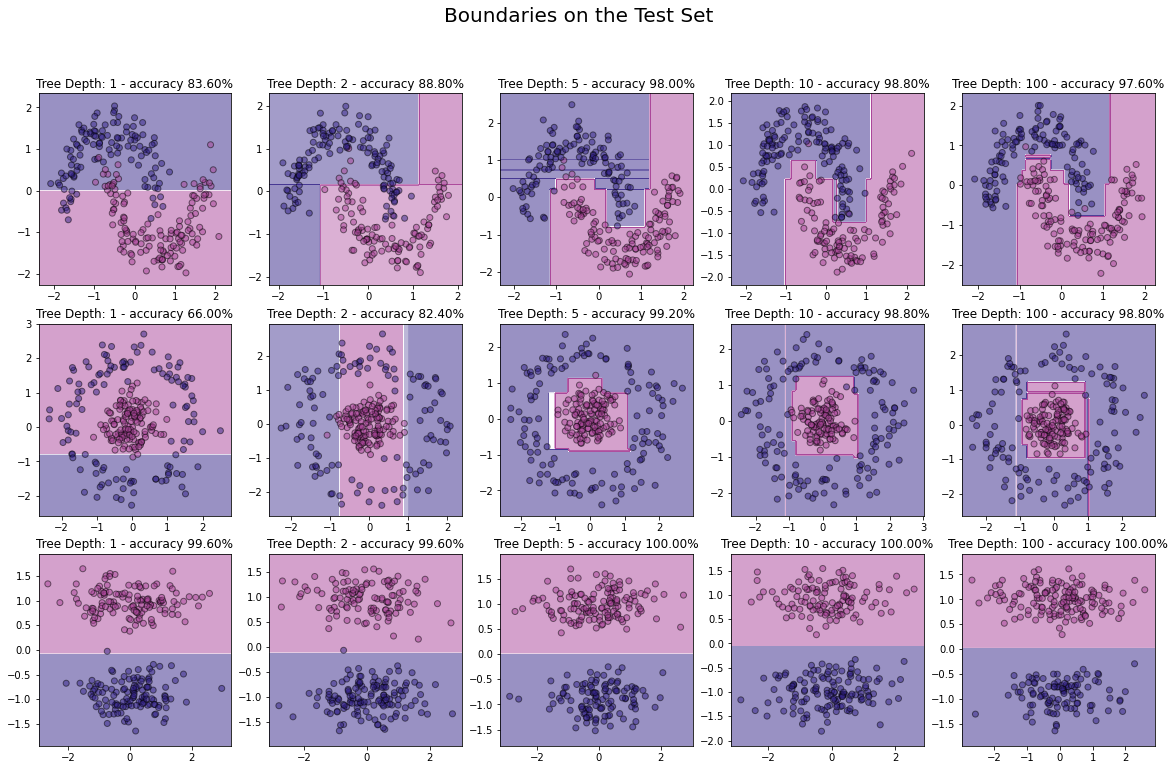

In [49]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(max_depths), figsize=(len(max_depths)*4,len(data_dict)*4),
    )

# looping over max_depths
for nd, data in enumerate(data_dict):
    for nmd, max_depth in enumerate(max_depths):
        
        # getting the current axis
        ax = axes[nd, nmd]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state.next())
        dt.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=dt,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='predict_proba',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'Tree Depth: {max_depth} - '\
            f'accuracy {accuracy_score(y_test, dt.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use a Decision Tree to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [50]:
bc_mean_features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


And our targets are:

In [51]:
bc_target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [52]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which parameters in the DT models might be the best predictor of breast cancer on this dataset. We will test different max depths and criterions.

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_state.next()), # the model
    param_grid={ # the parameters to change in the search
        'max_depth': [1, 2, 5, 10, 20, 50, 100,], # max depth
        'criterion': ['gini', 'entropy', 'log_loss'], # criterion
        }, 
    scoring='accuracy',  # how to score the parameters
    refit=True, # return the best model fitted on all of the training data
    cv=5, # the number of cross-validated folds
    verbose=1, # print lots of info as the code is running
    )

In [55]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=61397107),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [56]:
print('The results were:')
pd.DataFrame(gscv.cv_results_).head()

The results were:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000604,0.000082,0.000185,0.000025,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.941860,0.870588,0.870588,0.870588,0.882353,0.887196,0.027710,19
1,0.000694,0.000015,0.000144,0.000007,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.930233,0.894118,0.894118,0.905882,0.882353,0.901341,0.016250,16
2,0.001065,0.000087,0.000151,0.000008,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.953488,0.870588,0.941176,0.917647,0.882353,0.913051,0.032227,3
3,0.001187,0.000125,0.000195,0.000045,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.918605,0.858824,0.941176,0.905882,0.882353,0.901368,0.028544,12
4,0.001383,0.000074,0.000243,0.000029,gini,20,"{'criterion': 'gini', 'max_depth': 20}",0.918605,0.858824,0.941176,0.905882,0.882353,0.901368,0.028544,12


In [57]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'criterion': 'entropy', 'max_depth': 5}


In [58]:
best_model = gscv.best_estimator_
best_model

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=61397107)

The accuracy of this model on the test data is:

In [59]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 93.01%


## Random Forest

[Random Forest](https://en.wikipedia.org/wiki/Random_forest) is a classifier that is built on top of the work done by Decision Trees and is a type of ensemble learning model. This is because it uses a "forest" of decision trees when classifying data. 

During training many decision trees are built based on different random splits of the features and data (depending on the parameters), and during testing, the predictions of these trees are combined to get a single prediction.

See also https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

### The Basics

The decision tree classifier is easily imported from sklearn:

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
print(f"This has the default parameters:\n {RandomForestClassifier().get_params()}")

This has the default parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


What each of these parameters refers to can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We will investigate how this random forest can be used to classify data:

Similarly to earlier, we will start by seeing how we can train, and evaluate the performance of our model, and understand the model's decision boundary.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Here are the train and test splits of a synthetic dataset:

In [63]:
X, y = datasets.make_moons(1000, noise=0.15, random_state=random_state.next())

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

In [64]:
# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipykernel_7986/386109285.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


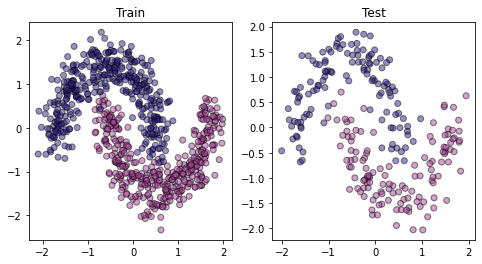

In [65]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

ax1.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax2.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')

ax1.set_title('Train')
ax2.set_title('Test')

fig.show()

The model can be fit as follows:

In [66]:
# start with linear kernel
rf = RandomForestClassifier(random_state=random_state.next())

In [67]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=139386294)

Let's evaluate the model and see how well its decision boundary fit the data:

In [68]:
from sklearn.metrics import accuracy_score

Without any tuning, this model already performs much better than SVM. Let us try and see why.

In [69]:
print(f"The accuracy is {accuracy_score(y_test, rf.predict(X_test))*100}%")

The accuracy is 97.6%


/tmp/ipykernel_7986/1647388345.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


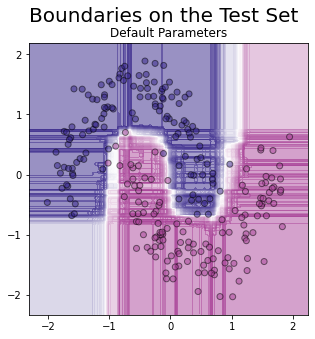

In [70]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

dbd = DecisionBoundaryDisplay.from_estimator(
    estimator=rf,
    X=X_test,
    grid_resolution=200,
    plot_method='contourf',
    response_method='predict_proba',
    ax=ax,
    cmap=binary_cmap,
    alpha=0.5,
    eps=0.3,
    levels=100,
    )

ax.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=0.5, cmap=binary_cmap, edgecolor='black')
ax.set_title('Default Parameters')
fig.suptitle('Boundaries on the Test Set', fontsize=20)
fig.show()

We can see that this fits the data much better than Decision Trees!

Let's study how the number of trees in the forest can effect the performance:

/tmp/ipykernel_7986/3479196455.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


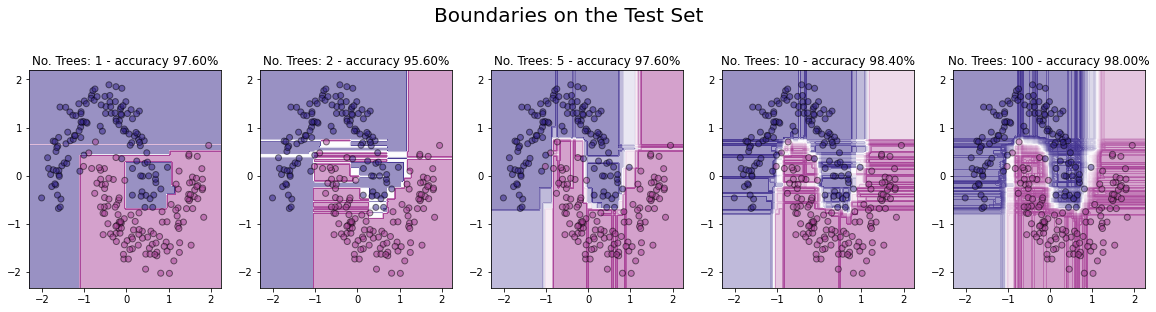

In [71]:
n_trees = [1, 2, 5, 10, 100,]

fig, axes = plt.subplots(1, len(n_trees), figsize=(len(n_trees)*4,4))

# looping over n_trees
for nmd, n_estimators in enumerate(n_trees):
    # getting the current axis
    ax = np.ravel(axes)[nmd]

    # fitting the model
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state.next())
    rf.fit(X_train, y_train)

    # plotting the decision boundary
    dbd = DecisionBoundaryDisplay.from_estimator(
        estimator=rf,
        X=X_test,
        grid_resolution=200,
        plot_method='contourf',
        response_method='predict_proba',
        ax=ax,
        cmap=binary_cmap,
        alpha=0.5,
        eps=0.3,
        levels=100,
        )
    
    # plotting the data
    ax.scatter(
        x=X_test[:,0], y=X_test[:,1], c=y_test, 
        alpha=0.5, cmap=binary_cmap, edgecolor='black'
        )

    # title
    ax.set_title(f'No. Trees: {n_estimators} - '\
        f'accuracy {accuracy_score(y_test, rf.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20, y=1.1)
fig.show()

Here, because multiple trees are used, and each of them is acting over a subset of the data, Random Forest is less likely to over-fit to the data as a single decision tree acting over all of the training data.

We see that even with a small number of trees, the performance is good!

Let's see how this model performs over different datasets:

In [72]:
# generating datasets
data_dict = {
    'moons': datasets.make_moons(
        1000, noise=0.15, random_state=random_state.next()
        ),
    'circles': datasets.make_circles(
        1000, noise=0.15, factor=0.2, random_state=random_state.next()
        ),
    'blobs': datasets.make_blobs(
        1000, centers=[[1, -1], [1, 1]], cluster_std=0.3, random_state=random_state.next(),
        ),
    }

In [73]:
# number of trees
n_trees = [1, 2, 5, 10, 100,]

/tmp/ipykernel_7986/1986406632.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


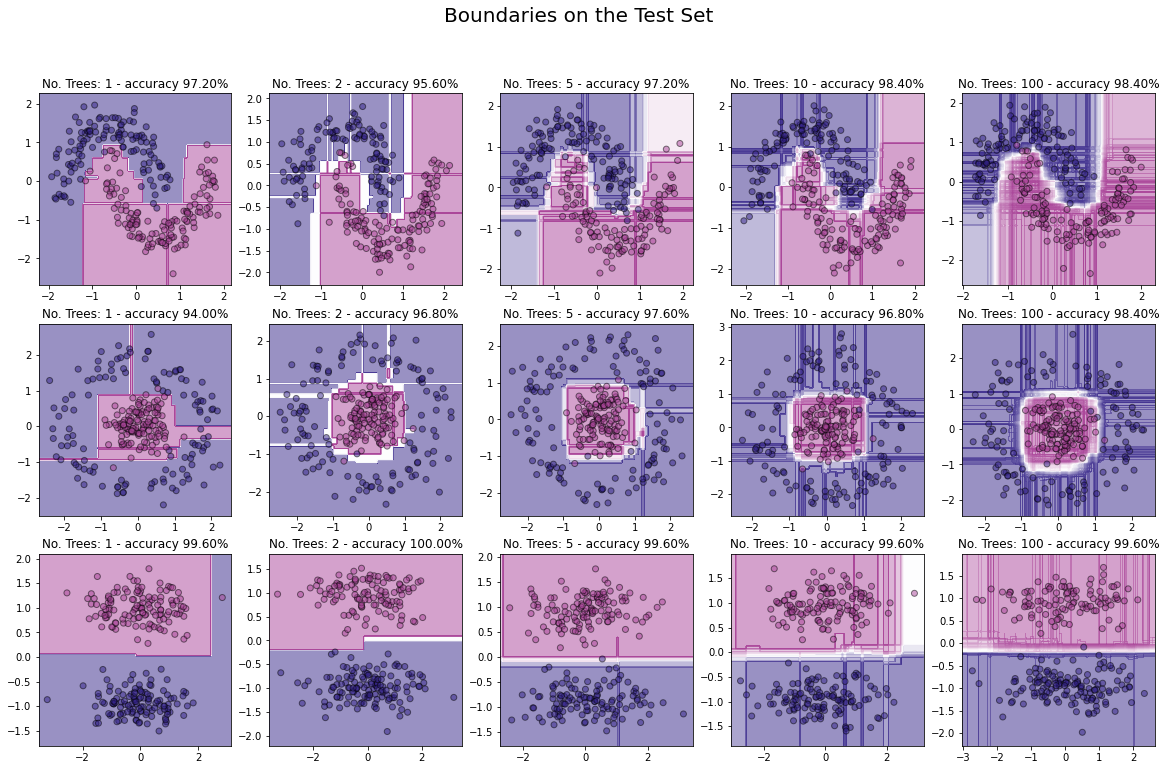

In [74]:
# plotting figure
fig, axes = plt.subplots(
    len(data_dict), len(n_trees), figsize=(len(n_trees)*4,len(data_dict)*4),
    )

# looping over n_trees
for nd, data in enumerate(data_dict):
    for nmd, n_estimators in enumerate(n_trees):
        
        # getting the current axis
        ax = axes[nd, nmd]

        # getting the data
        X, y = data_dict[data]

        # train-test splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, random_state=random_state.next()
            )

        # scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # fitting the model
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state.next())
        rf.fit(X_train, y_train)

        # plotting the decision boundary
        dbd = DecisionBoundaryDisplay.from_estimator(
            estimator=rf,
            X=X_test,
            grid_resolution=200,
            plot_method='contourf',
            response_method='predict_proba',
            ax=ax,
            cmap=binary_cmap,
            alpha=0.5,
            eps=0.3,
            levels=100,
            )
        
        # plotting the data
        ax.scatter(
            x=X_test[:,0], y=X_test[:,1], c=y_test, 
            alpha=0.5, cmap=binary_cmap, edgecolor='black'
            )

        # title
        ax.set_title(f'No. Trees: {n_estimators} - '\
            f'accuracy {accuracy_score(y_test, rf.predict(X_test))*100:.2f}%')

# figure title
fig.suptitle('Boundaries on the Test Set', fontsize=20)
# showing plot
fig.show()

### An Example

Now that we have an understanding of how this can be used in our generated examples, let's try to use a Random Forest to predict the classes on the breast cancer dataset that we introduced at the beginning of this notebook.

Our features are as follows:

In [75]:
bc_mean_features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


And our targets are:

In [76]:
bc_target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [77]:
# turning data from table to arrays
X, y = bc_mean_features.values, bc_target.values

# train-test splits:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=random_state.next()
    )

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We will use cross validation to understand which parameters in the DT models might be the best predictor of breast cancer on this dataset. We will test different max depths and criterions.

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
# setting up the cross validated grid search
gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=random_state.next()), # the model
    param_grid={ # the parameters to change in the search
        'max_depth': [1, 2, 5, 10, 20, 50, 100,], # max depth
        'criterion': ['gini', 'entropy', 'log_loss'], # criterion
        'n_estimators': [1, 2, 5, 10, 100, 200],
        }, 
    scoring='accuracy',  # how to score the parameters
    refit=True, # return the best model fitted on all of the training data
    cv=5, # the number of cross-validated folds
    verbose=1, # print lots of info as the code is running
    )

In [80]:
# fitting the model on the training data, with cross validation
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=751914956),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 5, 10, 20, 50, 100],
                         'n_estimators': [1, 2, 5, 10, 100, 200]},
             scoring='accuracy', verbose=1)

In [81]:
print('The results were:')
pd.DataFrame(gscv.cv_results_).head()

The results were:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001062,0.000121,0.000345,0.000073,gini,1,1,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.930233,0.882353,0.905882,0.941176,0.929412,0.917811,0.021139,75
1,0.001605,0.000049,0.000356,0.000030,gini,1,2,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.930233,0.882353,0.905882,0.941176,0.929412,0.917811,0.021139,75
2,0.003398,0.000062,0.000526,0.000035,gini,1,5,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.953488,0.917647,0.917647,0.917647,0.905882,0.922462,0.016168,71
3,0.006477,0.000292,0.000817,0.000138,gini,1,10,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.953488,0.882353,0.917647,0.870588,0.905882,0.905992,0.028997,116
4,0.060755,0.001185,0.004950,0.000109,gini,1,100,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.941860,0.870588,0.941176,0.929412,0.941176,0.924843,0.027523,64


In [82]:
print(f"The best set of parameters was {gscv.best_params_}")

The best set of parameters was {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


In [83]:
best_model = gscv.best_estimator_
best_model

RandomForestClassifier(criterion='entropy', max_depth=10,
                       random_state=751914956)

The accuracy of this model on the test data is:

In [84]:
print(f"The test accuracy is {accuracy_score(y_test, best_model.predict(X_test))*100:.2f}%")

The test accuracy is 95.80%
